
# ComputerVision-OpenCV-YOLO-DemoKit

This notebook demonstrates a compact toolkit of classic computer-vision techniques and modern object detection:

- **Harris Corner Detection** → `istockphoto-985915172-612x612.jpg`
- **Gaussian Image Pyramid** → `istockphoto-1384422450-612x612.jpg`
- **Watershed Segmentation** → `multi-colored-medicine-tablets-pills-260nw-2195950303.jpg`
- **SIFT Feature Detection** → `5adc6621ebf70feebd391ba129ccc5f5.jpg`
- **YOLOv8 Object Detection** → `1.jpg, 2.jpg, 3.jpg, 4.jpg, 5.jpg`

All task outputs are written to `Outputs/` with tidy subfolders.


In [ ]:
# Optional installs if needed in a clean environment
# %pip install --quiet opencv-python opencv-contrib-python ultralytics matplotlib numpy
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

def find_repo_root(start: Path, target_names=("Data","data"), max_hops=5)->Path:
    here = start.resolve()
    for _ in range(max_hops+1):
        for name in target_names:
            if (here/name).is_dir():
                return here
        if here.parent == here: break
        here = here.parent
    return start.resolve()

CWD = Path.cwd()
REPO_ROOT = find_repo_root(CWD)
DATA_DIR = (REPO_ROOT / "Data") if (REPO_ROOT / "Data").is_dir() else (REPO_ROOT / "data")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Create {REPO_ROOT/'Data'} and put the demo images there.")

OUTPUTS_DIR = REPO_ROOT / "Outputs"
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

def show(img_rgb, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb); plt.axis('off')
    if title: plt.title(title)
    plt.show()

def save_output(task, filename, img_rgb):
    out = OUTPUTS_DIR / task
    out.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out/filename), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    return out/filename

print("Repo root:", REPO_ROOT)
print("Data dir :", DATA_DIR)
print("Outputs  :", OUTPUTS_DIR)

Repo root: /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git
Data dir : /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Data
Outputs  : /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Outputs



## Setup



## Paths (auto-detect `Data/`)
The helper below finds `Data/` from wherever you run the notebook.



## Harris Corner Detection


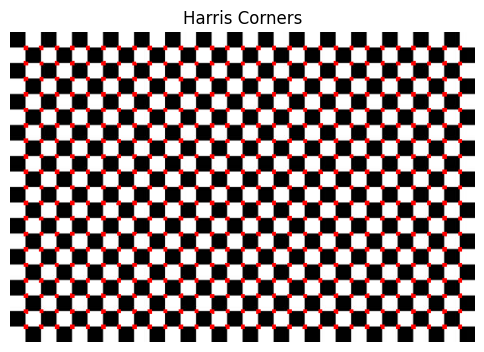

PosixPath('/Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Outputs/HARRIS/harris_result.png')

In [ ]:
img_path = DATA_DIR / "istockphoto-985915172-612x612.jpg"
img_bgr = cv2.imread(str(img_path))
if img_bgr is None:
    raise FileNotFoundError(f"Missing image: {img_path}")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)

dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst, None)
overlay = img.copy()
overlay[dst > 0.01 * dst.max()] = [255, 0, 0]

show(overlay, title="Harris Corners")
save_output("HARRIS", "harris_result.png", overlay)


## Gaussian Image Pyramid


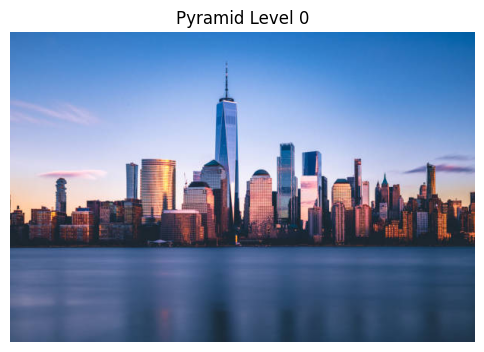

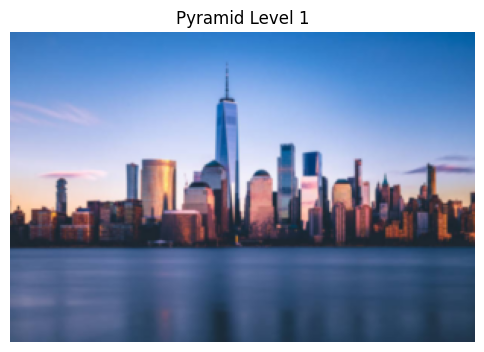

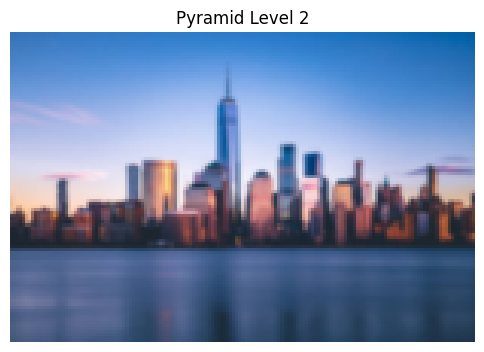

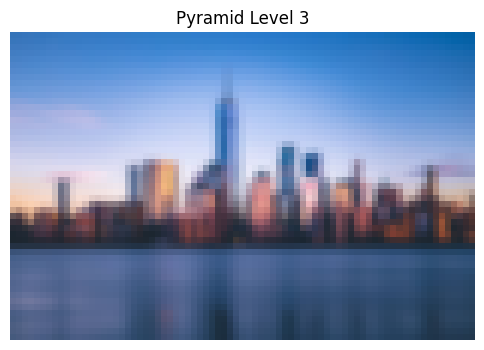

In [ ]:
img_path = DATA_DIR / "istockphoto-1384422450-612x612.jpg"
img_bgr = cv2.imread(str(img_path))
if img_bgr is None:
    raise FileNotFoundError(f"Missing image: {img_path}")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

levels = 3
pyr = [img]
curr = img
for _ in range(levels):
    curr = cv2.pyrDown(curr)
    pyr.append(curr)

for i, level_img in enumerate(pyr):
    show(level_img, title=f"Pyramid Level {i}")
    save_output("PYRAMID", f"pyrL{i}.png", level_img)


## Watershed Segmentation


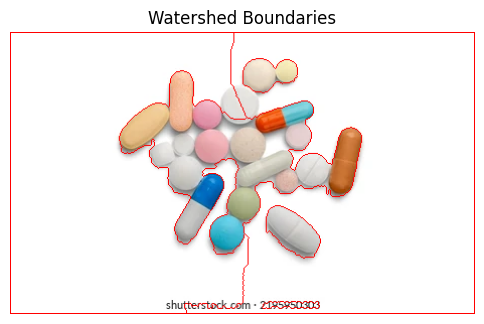

PosixPath('/Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Outputs/WATERSHED/watershed_result.png')

In [ ]:
img_path = DATA_DIR / "multi-colored-medicine-tablets-pills-260nw-2195950303.jpg"
img_bgr = cv2.imread(str(img_path))
if img_bgr is None:
    raise FileNotFoundError(f"Missing image: {img_path}")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

num_labels, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), markers)
result = img.copy()
result[markers == -1] = [255, 0, 0]

show(result, title="Watershed Boundaries")
save_output("WATERSHED", "watershed_result.png", result)


## SIFT Feature Detection


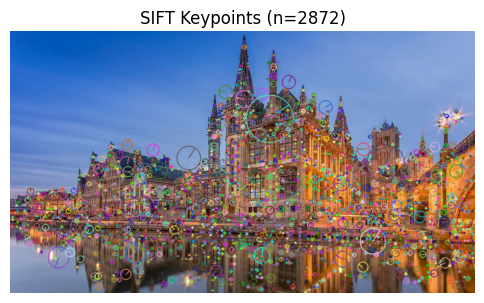

PosixPath('/Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Outputs/SIFT/sift_result.png')

In [ ]:
if not hasattr(cv2, "SIFT_create"):
    raise ImportError("Install 'opencv-contrib-python' to use SIFT.")

img_path = DATA_DIR / "5adc6621ebf70feebd391ba129ccc5f5.jpg"
img_bgr = cv2.imread(str(img_path))
if img_bgr is None:
    raise FileNotFoundError(f"Missing image: {img_path}")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()
kpts, desc = sift.detectAndCompute(gray, None)
vis = cv2.drawKeypoints(img, kpts, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show(vis, title=f"SIFT Keypoints (n={len(kpts)})")
save_output("SIFT", "sift_result.png", vis)


## YOLOv8 Object Detection


100%|██████████| 6.25M/6.25M [00:00<00:00, 62.7MB/s]

image 1/1 /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Data/1.jpg: 480x640 5 persons, 2 skateboards, 39.1ms
Speed: 1.2ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


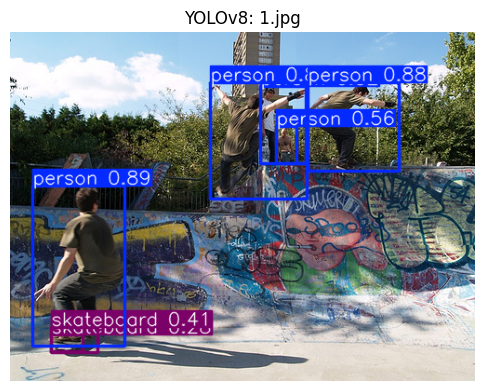


image 1/1 /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Data/2.jpg: 448x640 5 wine glasss, 1 knife, 2 bowls, 1 carrot, 1 dining table, 38.9ms
Speed: 0.7ms preprocess, 38.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


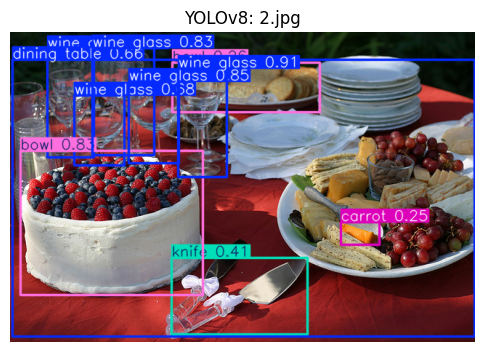


image 1/1 /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Data/3.jpg: 544x640 6 birds, 48.2ms
Speed: 1.4ms preprocess, 48.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


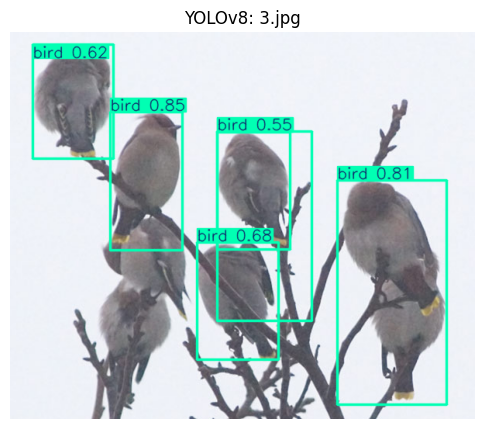


image 1/1 /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Data/4.jpg: 480x640 2 motorcycles, 34.6ms
Speed: 0.6ms preprocess, 34.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


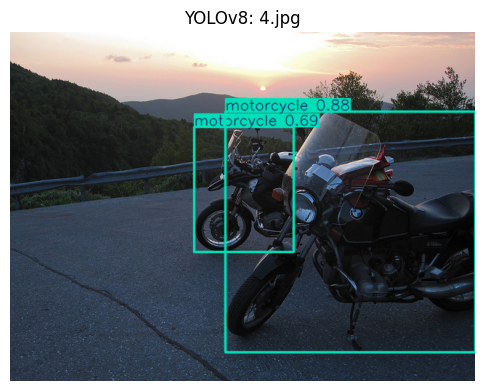


image 1/1 /Users/rohitsaikiran/Downloads/AI-Course/Vision-systems/A2/git/Data/5.jpg: 416x640 19 persons, 2 ties, 59.1ms
Speed: 0.9ms preprocess, 59.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


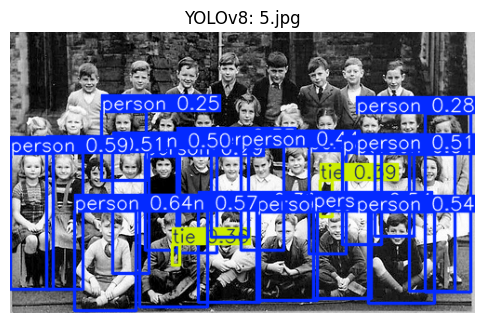

In [ ]:
from ultralytics import YOLO
weights_local = DATA_DIR / "models" / "yolov8n.pt"
model = YOLO(str(weights_local)) if weights_local.exists() else YOLO("yolov8n.pt")

targets = [DATA_DIR / n for n in ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']]
for p in targets:
    if not p.exists():
        raise FileNotFoundError(f"Missing image: {p}")

for p in targets:
    res = model(str(p))[0]
    plotted = cv2.cvtColor(res.plot(), cv2.COLOR_BGR2RGB)
    show(plotted, title=f"YOLOv8: {p.name}")
    save_output("YOLO", f"yolo_{p.stem}.png", plotted)

---

### Author  
**Rohit Ravula**  

📧 **Email:** [rohitsaikiran.r@gmail.com](mailto:rohitsaikiran.r@gmail.com)  
🐙 **GitHub:** [@Rohit-Sai-Kiran](https://github.com/RohitSaiKiran)

---
